Get dataset from https://github.com/OlafenwaMoses/FireNET
combine train and validate source sets, as these are split in code

## EfficientDet
https://airctic.com/model_efficientdet/

In [1]:
!wget https://github.com/OlafenwaMoses/FireNET/releases/download/v1.0/fire-dataset.zip -q

In [2]:
!unzip fire-dataset.zip

Archive:  fire-dataset.zip
   creating: fire-dataset/
   creating: fire-dataset/train/
   creating: fire-dataset/train/annotations/
  inflating: fire-dataset/train/annotations/img (100).xml  
  inflating: fire-dataset/train/annotations/img (101).xml  
  inflating: fire-dataset/train/annotations/img (102).xml  
  inflating: fire-dataset/train/annotations/img (103).xml  
  inflating: fire-dataset/train/annotations/img (104).xml  
  inflating: fire-dataset/train/annotations/img (105).xml  
  inflating: fire-dataset/train/annotations/img (106).xml  
  inflating: fire-dataset/train/annotations/img (107).xml  
  inflating: fire-dataset/train/annotations/img (108).xml  
  inflating: fire-dataset/train/annotations/img (109).xml  
  inflating: fire-dataset/train/annotations/img (110).xml  
  inflating: fire-dataset/train/annotations/img (111).xml  
  inflating: fire-dataset/train/annotations/img (112).xml  
  inflating: fire-dataset/train/annotations/img (113).xml  
  inflating: fire-dataset/tr

In [3]:
!rm  fire-dataset.zip

Merge the train and validation datasets as we split later

In [4]:
cp fire-dataset/validation/annotations/* fire-dataset/train/annotations/

In [5]:
cp fire-dataset/validation/images/* fire-dataset/train/images/

In [6]:
!rm  -r fire-dataset/validation/

In [7]:
!ls fire-dataset/train

annotations  images


In [8]:
!pip install icevision[all] icedata -q

     |████████████████████████████████| 122kB 11.4MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 194kB 17.2MB/s 
     |████████████████████████████████| 1.8MB 19.0MB/s 
     |████████████████████████████████| 552kB 42.2MB/s 
     |████████████████████████████████| 112kB 43.3MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 952kB 44.7MB/s 
     |████████████████████████████████| 36.7MB 85kB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 133kB 44.5MB/s 
     |████████████████████████████████| 102kB 10.8MB/s 
     |████████████████████████████████| 163kB 43.5MB/s 
     |████████████████████████████████| 92kB 10.2MB/s 
     |

In [9]:
# import icevision
# icevision.__version__

0.4.0

In [10]:
from icevision.all import *
# from fastai.callback.wandb import *
# from fastai.callback.tracker import SaveModelCallback

In [11]:
data_dir = Path('fire-dataset/train')
data_dir

Path('fire-dataset/train')

In [12]:
images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

In [13]:
image_files = [i for i in images_dir.glob('*')]
image_files[:3]

[Path('fire-dataset/train/images/img (28).jpg'),
 Path('fire-dataset/train/images/small (55).jpg'),
 Path('fire-dataset/train/images/small (1).jpg')]

In [14]:
annotation_files = [i for i in annotations_dir.glob('*')]
annotation_files[:3]

[Path('fire-dataset/train/annotations/img (130).xml'),
 Path('fire-dataset/train/annotations/img (51).xml'),
 Path('fire-dataset/train/annotations/pic (194).xml')]

In [16]:
class_map = ClassMap(['fire'])
print(class_map)

<ClassMap: {'background': 0, 'fire': 1}>


In [17]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

In [18]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

INFO     - Autofixing records | icevision.parsers.parser:parse:124


In [19]:
len(train_records)

401

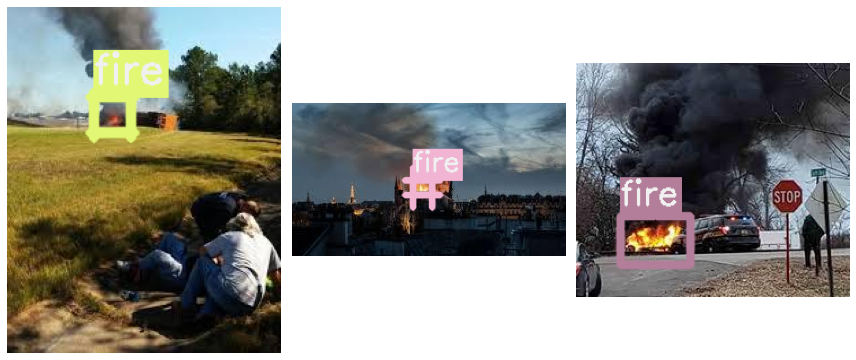

In [20]:
show_records(train_records[:3], ncols=3, class_map=class_map)

In [21]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

The Dataset class combines the records and transforms.

In [22]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Displaying the same image with different transforms

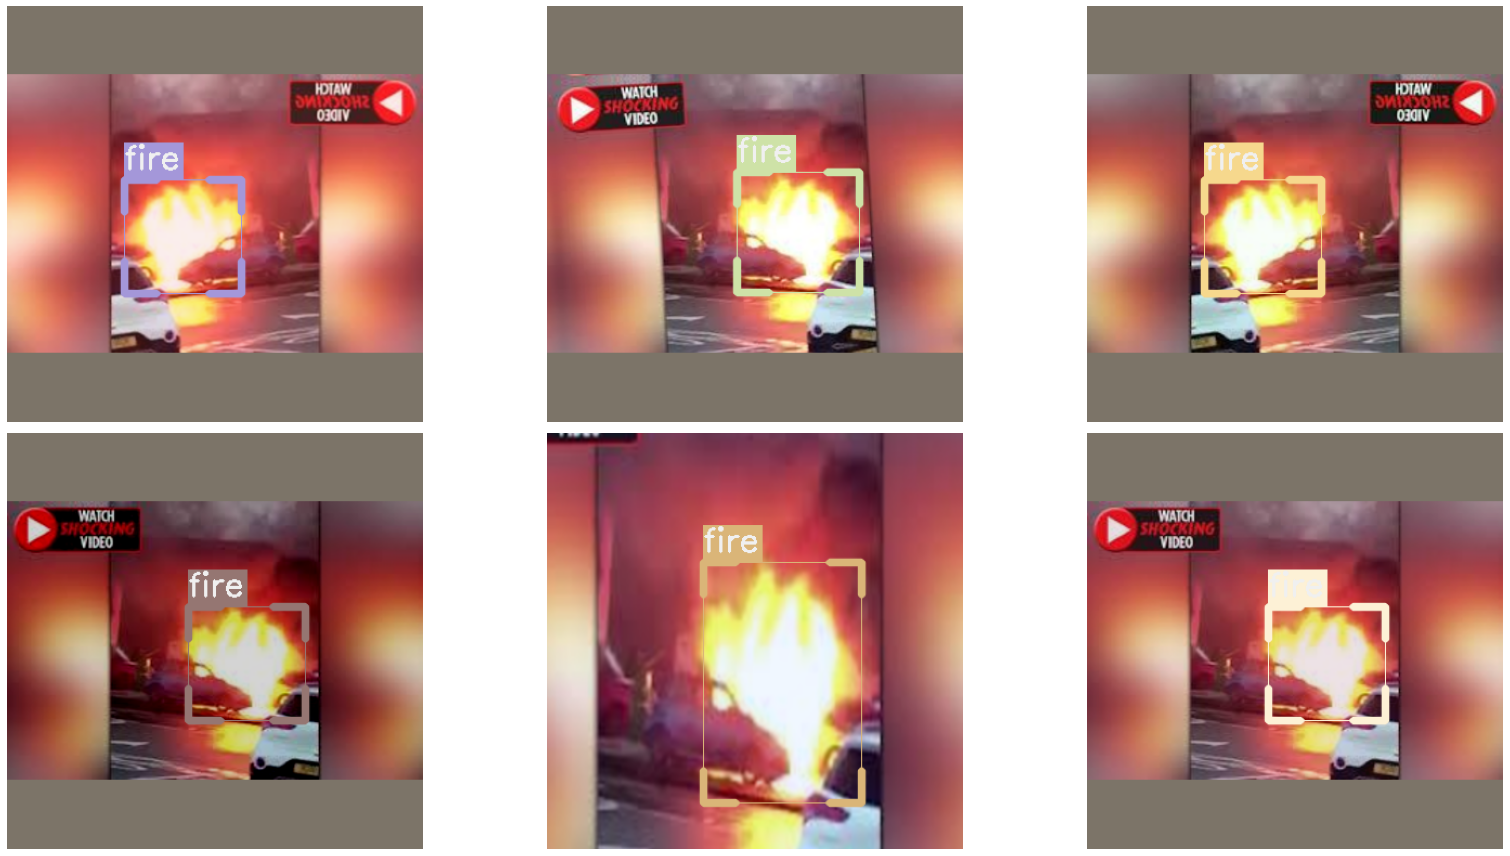

In [23]:
samples = [train_ds[3] for _ in range(6)]
show_samples(samples, ncols=3, class_map=class_map)

## EffecientDet
https://airctic.com/model_efficientdet/

EffecientDet is one of the effecient and fastest object detection model that also uses more constrained resources in comparison to other models 

The model accepts a variety of backbones. We can choose one of the efficientdet_d0 to efficientdet_d7 backbones, and MobileNetv3 classes (which also includes MNasNet, MobileNetV2, MixNet and more)

In [24]:
model = efficientdet.model(
    model_name="tf_efficientdet_d2", 
    num_classes=len(class_map), 
    img_size=size
)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d2_43-8107aa99.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_d2_43-8107aa99.pth


Each model has its own dataloader (a pytorch `DataLoader`) that could be customized

In [25]:
# DataLoaders
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

Metrics are essential for tracking the model progress as it's training.
Here we are going to be using the well established COCOMetric, which reports on the mean average precision of the predictions.

In [26]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [27]:
# wandb.init(project="icevision-firenet", name="efficientdet_d2", reinit=True)

In [28]:
# Fastai Learner
learn = efficientdet.fastai.learner(
    dls=[train_dl, valid_dl], 
    model=model, 
    metrics=metrics,
    # cbs=[WandbCallback(log_dataset=True, log_model=True), SaveModelCallback()]
)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

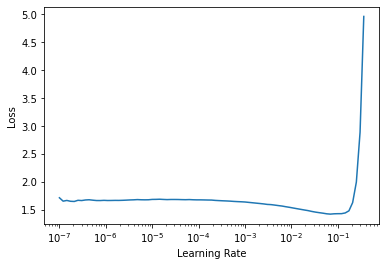

In [29]:
# Fastai Training
learn.freeze()
learn.lr_find()

In [30]:
learn.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.281412,1.415584,0.011945,00:22


epoch,train_loss,valid_loss,COCOMetric,time
0,0.937693,0.965287,0.105877,00:27
1,0.873492,0.844720,0.180091,00:26
2,0.810367,1.052932,0.139818,00:25
3,0.751147,1.447558,0.138044,00:25
4,0.722514,1.155541,0.165378,00:25
5,0.683732,0.981074,0.249215,00:25
6,0.650334,0.802614,0.288743,00:25
7,0.609517,0.755160,0.305717,00:25
8,0.579313,0.580188,0.383761,00:26
9,0.552442,0.561585,0.385370,00:25


After 10 epochs achieve COCOMetric 0.39, which is already better than faster-rcnn

Now do more epochs, reduce lr

In [ ]:
learn.fine_tune(50, 1e-4, freeze_epochs=10)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.508579,0.564069,0.369945,00:23


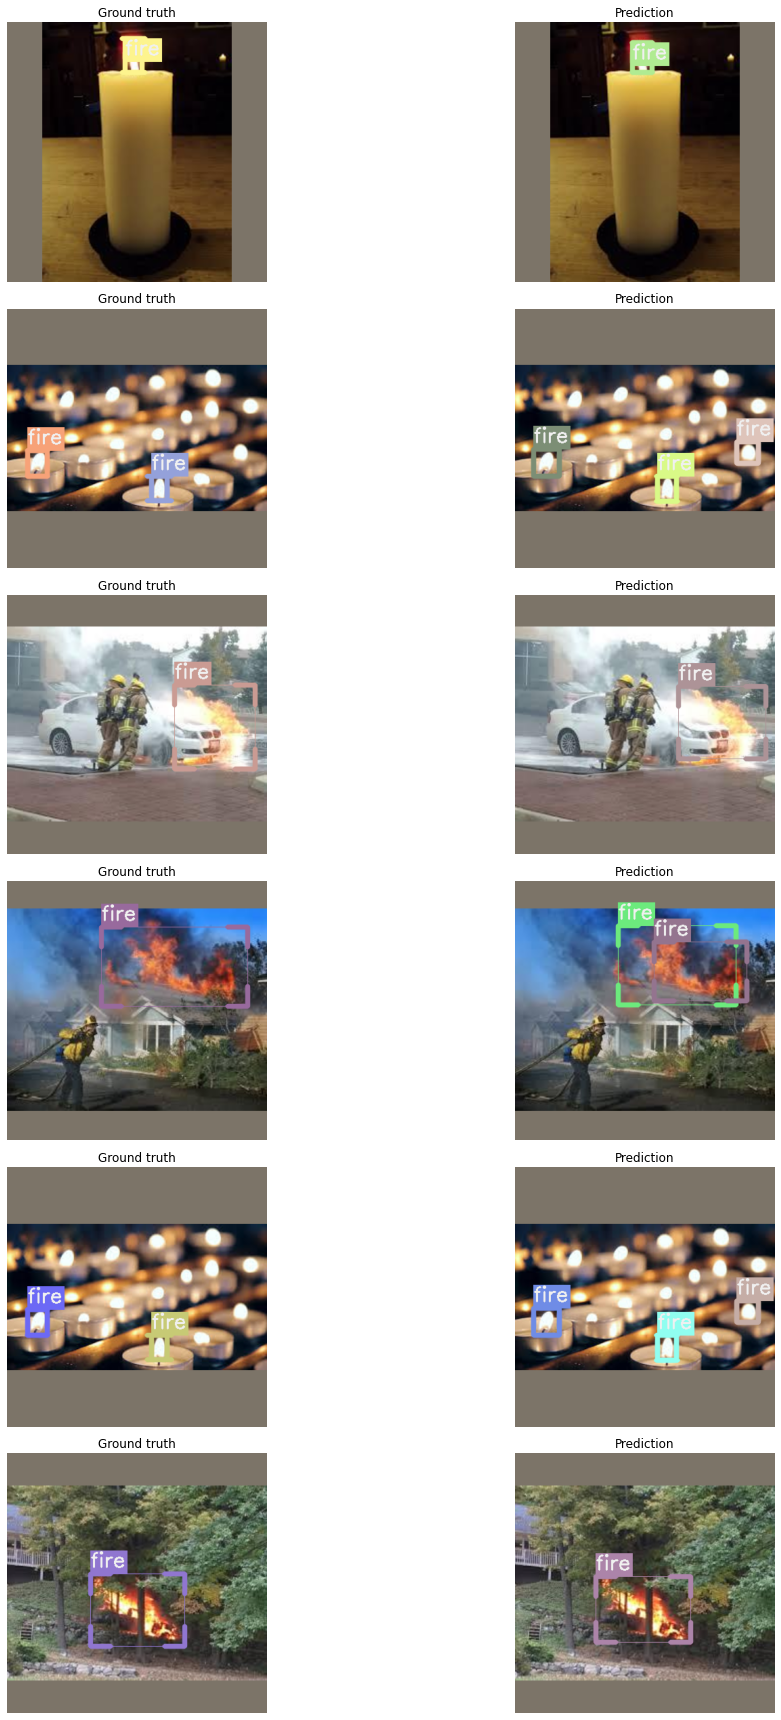

In [31]:
efficientdet.show_results(model, valid_ds, class_map=class_map)

## Inference

In [ ]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=8)
samples, preds = efficientdet.predict_dl(model=model, infer_dl=infer_dl)

In [ ]:
from icevision.visualize.wandb_img import *
wandb_images = wandb_img_preds(samples, preds, class_map, add_ground_truth=True) 

UnboundLocalError: ignored

In [ ]:
wandb.log({"Predicted images": wandb_images})

In [ ]:
# optional: mark the run as completed
wandb.join()

https://airctic.github.io/icedata/how-to/#how-to-save-trained-weights-in-google-colab

In [ ]:

## Saving a Model on Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

torch.save(model.state_dict(), root_dir/'models/icedata/efficientdet_fire.pth')

`"efficientdet_fire.pth" (13MB)`